In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### load data

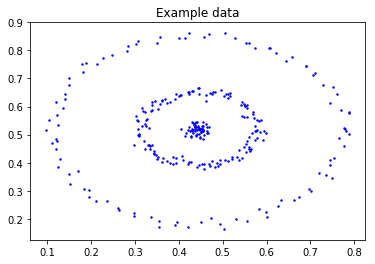

In [4]:
from scipy.io import loadmat

A = loadmat('Data2.mat')
n = len(A['data'])
p = len(A['data'][0])

for i in range(n):
    plt.scatter(A['data'][i][0],A['data'][i][1], s=2, c="blue")
plt.title("Example data")
plt.show()

###  check the distribution of nearest neighbors

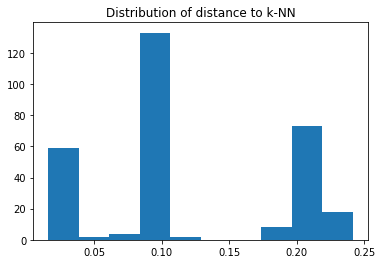

In [5]:
from scipy.spatial.distance import squareform, pdist

D = squareform(pdist(A['data']))

test_flag = 1
list1 = []

if test_flag:
    D_sort = sort(D,1)
    k=30
    
    for i in range(len(D_sort)):
        list1.append( D_sort[i][k+1] )    
    dist_knn = np.array(list1)
    
    median_val = median(dist_knn)
    eps_val = median_val*median_val/2
    sigmaK = sqrt(2)*median_val
    
    plt.hist(dist_knn)
    plt.title('Distribution of distance to k-NN')
    plt.show()

### set parameters in model

In [6]:
eps_val=0.05
neigen=10        #undifine=0
flag_t=0
if flag_t:
    t=3

### eigendecomposition

In [255]:
def diffuse(D,eps_val,neigen,t):
    
    n=len(D[0])
    
    K=get_K(D, eps_val)
    
    v=get_v(D, K)
    
    A=get_A(K, v)
    
    [psi, phi, eigenvals]=get_psiphi(A)

    X = get_X(eigenvals, neigen, psi, t)

    
    return X, eigenvals, psi, phi

In [256]:
def get_K(D, eps_val):
    list1=[]

    for i in range(n):
        for j in range(n):
            list1.append( exp(-D[i][j]*D[i][j]/(4*eps_val)) )
    K = np.array(list1).reshape(n, n)
    
    return K

In [257]:
def get_v(D, K):
    list1=[]
    
    for i in range(n):
        list1.append( sqrt(sum(K[i])) )
    v = np.array(list1).reshape(n,1)
    
    return v

In [258]:
from scipy.sparse import csr_matrix

def get_A(K, v):
    A = K/(v*v.T)
    threshold = 5e-6
    
    list1=[]
    list2=[]
    
    for i in range(n):
        for j in range(n):
            if A[i][j]>threshold:
                list1.append(1.)
            else: list1.append(0.)
    b = np.array(list1).reshape(n, n)
    
    A = csr_matrix(A*b, dtype=np.float)
    #AA = np.array(A)
    #A = A.T
    return A

In [259]:
from scipy.sparse.linalg import svds

def get_psiphi(A):
    list1=[]
    
    if neigen is 0:
        [U, S, V] = svds(A, 51)
        for i in range(n):
            for j in range(51):
                list1.append( U[i][0] )
        temp = np.array(list1).reshape(n, 51)
        psi = U/temp
        phi = U*temp
    else:
        [U, S, V] = svds(A, neigen+1)

        for i in range(n):
            for j in range(neigen+1):
                list1.append( U[i][0] )
        temp = np.array(list1).reshape(n, neigen+1)
        psi = U/temp
        phi = U*temp
        
    """
    print(U)
    print(len(psi),len(psi[0]))
    print(psi)
    print(phi)
    
    """

    S = flip(S)
    eigenvals = np.array(S).reshape(len(S), 1)
    
    return [psi, phi, eigenvals]

In [260]:
def get_X(eigenvals, neigen, psi, t):
    list1=[]
    list2=[]
    list3=[]
    list4=[]
    
    if t is 0:
        for i in range(n):
            for j in range(1, len(eigenvals)):
                list1.append( pow(eigenvals[j], t) )
        lambda_t = np.array(list1).reshape(n, len(eigenvals)-1)

        if neigen is 0:
            for i in range(len(eigenvals)):
                list2.append( lambda_t[0][i])/(lambda_t[0][0] )
            lam = np.array(list2)
            
            for i in range(len(eigenvals)):
                if lam[i]<0.05:
                    list3.append(lam[i])
            neigen = min(list3)
            neigen = min(neigen, 50)
        
        for i in range(n):
            for j in range(neigen):
                list4.append(psi[i][j+1]*lambda_t[i][j])
        X = np.array(list4).reshape(n, neigen)
    else:
        for i in range(n):
            for j in range(1, len(eigenvals)):
                list1.append( eigenvals[j]/(1-eigenvals[j]) )
        lambda_multi = np.array(list1).reshape(n, len(eigenvals)-1)
        
        if neigen is 0:
            for i in range(len(eigenvals)):
                list2.append( lambda_multi[0][i])/(lambda_t[0][0] )
            lam = np.array(list2)
            
            for i in range(len(eigenvals)):
                if lam[i]<0.05:
                    list3.append(lam[i])
            neigen = min(list3)
            neigen = min(neigen, 50)
        
        for i in range(n):
            for j in range(neigen):
                list4.append(psi[i][j+1]*lambda_multi[i][j])
        X = np.array(list4).reshape(n, neigen)
    
    return X

In [262]:
X, eigenvals, psi, phi = diffuse(D, eps_val, neigen, 1)

### diffusion k-means

In [244]:
k=2
Niter=100

list1=[]
for i in range(n):
    list1.append(phi[i][0])
phi0=np.array(list1).reshape(n,1)
list1.clear()

In [245]:
from math import ceil
import random as rnd

def diffusion_kmeans(X, k, phi0, Niter, epsilon):
    
    N=len(X)
    d=len(X[0])
    aD=Inf
    if epsilon is 0: epsilon=1e-3
        
    for i in range(Niter):
        tmp_ind = rnd.sample(range(N), k)
    
        list1=[]
        for i in tmp_ind:
            for j in range(d):
                list1.append(X[i][j])
        c_0 = np.array(list1).reshape(k, d)
    
        [idx, c, cindex, D, DX]=distortionMinimization(X, phi0, k, c_0, 0, epsilon)
    
        if D<aD:
            aD=D
            aDX=DX
            a_idx=idx
            ac=c
    D=aD
    DX=aDX
    idx=a_idx
    C=ac
    
    return idx, C, D, DX

In [ ]:
def distortionMinimization(X, phi0, k, c_0, DspFlag, epsilon):
    n=len(X)
    d=len(X[0])
    c=c_0
    oldD=Inf
    MaxIter=1000
    
    
    for i in range(MaxIter):
        DX=[]
        for j in range(k):
            dX=X
    

In [226]:
diffusion_kmeans(X, k, phi0, Niter, 0.001)

299 10
